In [1]:
import sys
import xarray as xr
import numpy as np
import pandas as pd
import math
import glob
import yaml
import geopandas as gpd
import cartopy
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.colorbar import Colorbar # different way to handle colorbar
import matplotlib.ticker as mticker
import cmocean.cm as cmo

# cartopy
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
import cartopy.feature as cfeature
import dask

# import personal modules
# Path to modules
sys.path.append('../modules')
# Import my modules
from utils import roundPartial, select_months_ds
from plotter import draw_basemap, plot_terrain, plot_arscale_cbar
from colorline import colorline
from trajectory import calculate_heatmaps_from_trajectories
import customcmaps as ccmaps

dask.config.set(**{'array.slicing.split_large_chunks': True})

ERROR 1: PROJ: proj_create_from_database: Open of /home/dnash/miniconda3/envs/SEAK-clim/share/proj failed


In [2]:
server='skyriver'
if server == 'comet':
    path_to_data = '/data/projects/Comet/cwp140/'
elif server == 'expanse':
    path_to_data = '/expanse/lustre/scratch/dnash/temp_project/'
elif server == 'skyriver':
    path_to_data = '/home/dnash/comet_data/'
path_to_out  = '../out/'       # output files (numerical results, intermediate datafiles) -- read & write
path_to_figs = '../figs/'      # figures

In [ ]:
HUC8_ID = 14050001 ## Upper Yampa

In [17]:
## load PRISM watershed precip dataset
fname = path_to_data + 'preprocessed/PRISM/PRISM_HUC8_CO.nc'
PRISM = xr.open_dataset(fname)
PRISM = PRISM.sel(HUC8=str(HUC8_ID))
PRISM = PRISM.where(PRISM.extreme == 1, drop=True)
PRISM

<xarray.Dataset>
Dimensions:  (date: 174)
Coordinates:
  * date     (date) datetime64[ns] 2000-01-19 2000-02-11 ... 2019-12-15
    HUC8     <U8 '14050001'
Data variables:
    prec     (date) float64 11.84 14.86 11.19 13.4 ... 29.14 12.05 12.74 11.59
    extreme  (date) float64 1.0 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0 1.0
    lat      (date) float64 40.45 40.45 40.45 40.45 ... 40.45 40.45 40.45 40.45
    lon      (date) float64 -107.1 -107.1 -107.1 -107.1 ... -107.1 -107.1 -107.1

In [11]:

fname = '/home/dnash/comet_data/preprocessed/ERA5_trajectories/final/PRISM_HUC8_{0}.nc'.format(HUC8_ID)
# fname = path_to_data + 'preprocessed/ERA5_trajectories/final/PRISM_HUC8_{0}.nc'.format(HUC8_ID)
final_ds = xr.open_dataset(fname)
final_ds

<xarray.Dataset>
Dimensions:       (start_date: 174, index: 72)
Coordinates:
    lat           (start_date, index) float64 ...
    lon           (start_date, index) float64 ...
    time          (start_date, index) datetime64[ns] ...
  * index         (index) int64 0 1 2 3 4 5 6 7 8 ... 63 64 65 66 67 68 69 70 71
  * start_date    (start_date) datetime64[ns] 2000-01-19 ... 2019-12-15
Data variables: (12/13)
    IVT           (start_date, index) float64 ...
    uIVT          (start_date, index) float64 ...
    vIVT          (start_date, index) float64 ...
    IWV           (start_date, index) float64 ...
    level         (start_date, index) float64 ...
    q             (start_date, index) float64 ...
    ...            ...
    v             (start_date, index) float64 ...
    w             (start_date, index) float64 ...
    dq            (start_date, index) float64 ...
    drying_ratio  (start_date, index) float64 ...
    ar_scale      (start_date) float64 ...
    ar            (start_date) float64 ...
Attributes:
    Conventions:                CF-1/0
    history:                    Fri Jul 17 10:25:04 2020: /apps/nco-4.9.3_gnu...
    history_of_appended_files:  Fri Jul 17 10:25:04 2020: Appended file ERA5_...
    NCO:                        netCDF Operators version 4.9.3 (Homepage = ht...

In [20]:
final_ds = final_ds.isel(start_date = [-2, -1])

In [21]:
final_ds

<xarray.Dataset>
Dimensions:       (start_date: 2, index: 72)
Coordinates:
    lat           (start_date, index) float64 ...
    lon           (start_date, index) float64 ...
    time          (start_date, index) datetime64[ns] ...
  * index         (index) int64 0 1 2 3 4 5 6 7 8 ... 63 64 65 66 67 68 69 70 71
  * start_date    (start_date) datetime64[ns] 2019-12-13 2019-12-15
Data variables: (12/13)
    IVT           (start_date, index) float64 ...
    uIVT          (start_date, index) float64 ...
    vIVT          (start_date, index) float64 ...
    IWV           (start_date, index) float64 ...
    level         (start_date, index) float64 ...
    q             (start_date, index) float64 ...
    ...            ...
    v             (start_date, index) float64 ...
    w             (start_date, index) float64 ...
    dq            (start_date, index) float64 ...
    drying_ratio  (start_date, index) float64 ...
    ar_scale      (start_date) float64 ...
    ar            (start_date) float64 ...
Attributes:
    Conventions:                CF-1/0
    history:                    Fri Jul 17 10:25:04 2020: /apps/nco-4.9.3_gnu...
    history_of_appended_files:  Fri Jul 17 10:25:04 2020: Appended file ERA5_...
    NCO:                        netCDF Operators version 4.9.3 (Homepage = ht...

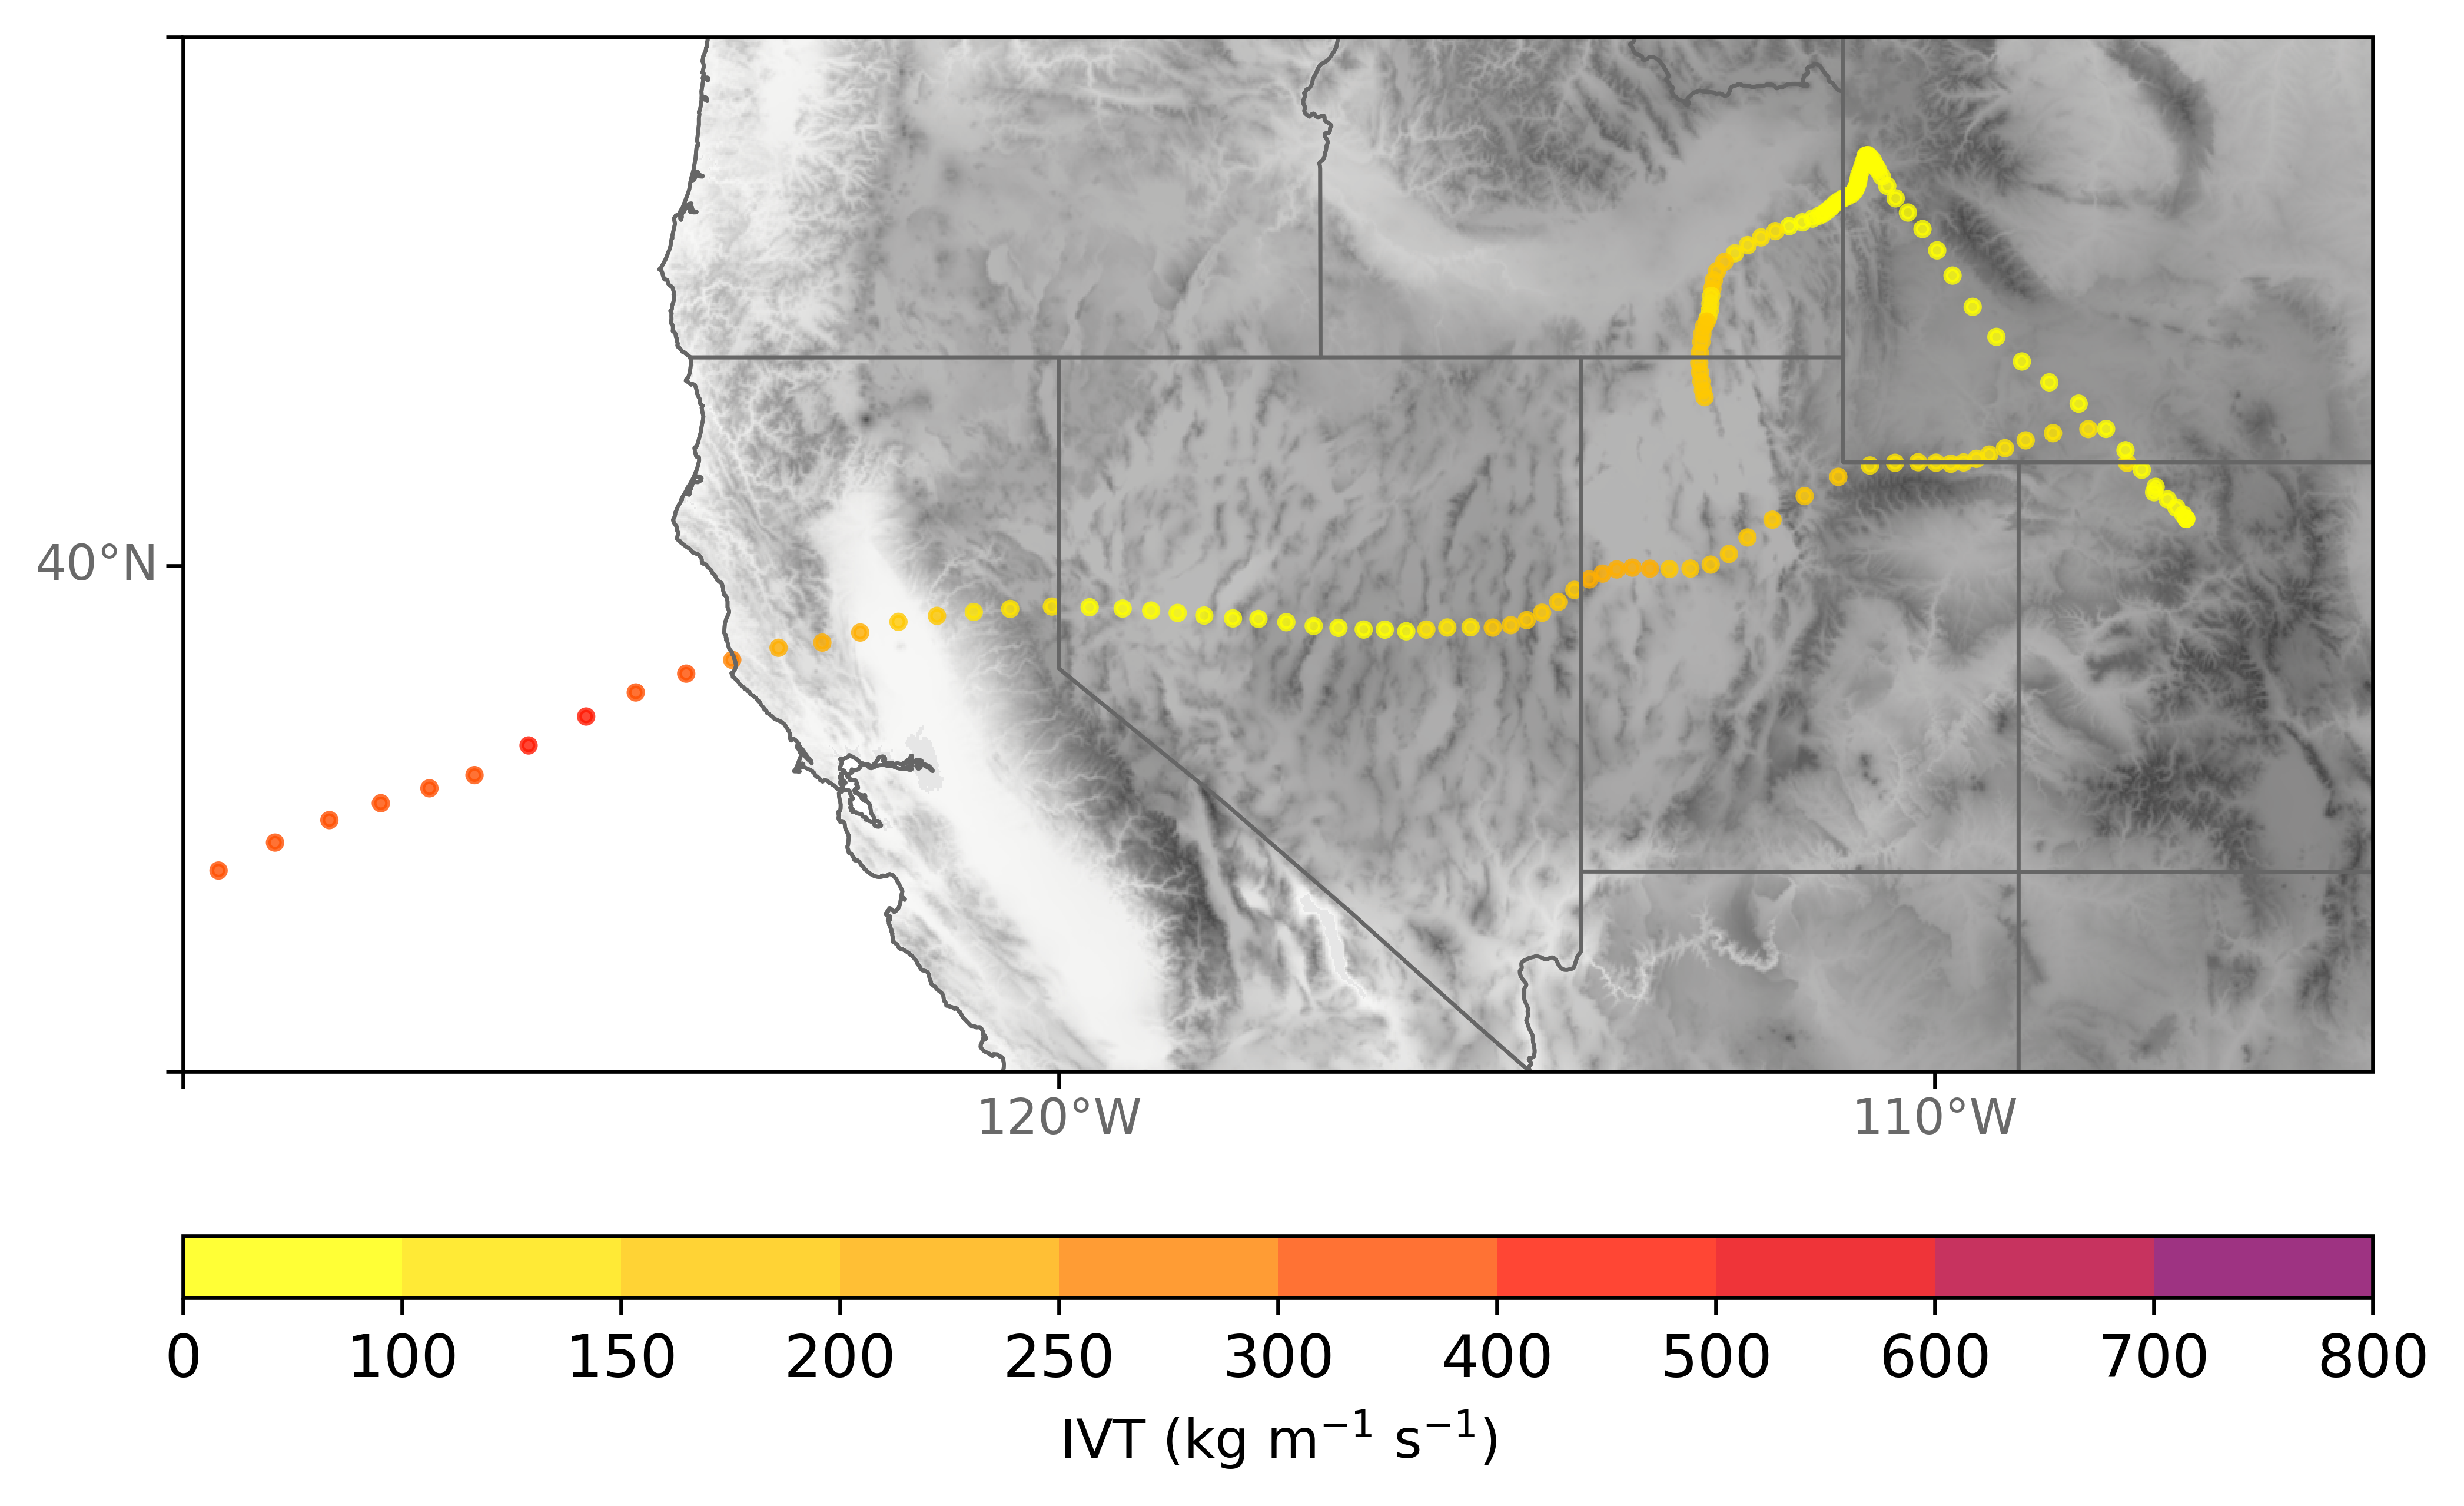

In [35]:
ds_lst = [final_ds]
nrows = 2
ncols = 1

## Use gridspec to set up a plot with a series of subplots that is
## n-rows by n-columns
gs = GridSpec(nrows, ncols, height_ratios=[1, 0.05], width_ratios = [1], wspace=0.01, hspace=0.1)
## use gs[rows index, columns index] to access grids

fig = plt.figure(figsize=(8.0, 5.0))
fig.dpi = 600
fname = path_to_figs + 'Dec2019_case_study_trajectory'
fmt = 'png'

############################
### PLOT IVT VALUES ###
############################
datacrs = ccrs.PlateCarree()  ## the projection the data is in
mapcrs = ccrs.Miller() ## the projection you want your map displayed in
ext = [-130., -105., 35., 45.]
# Set tick/grid locations
tx = 10
ty = 5
dx = np.arange(ext[0],ext[1]+tx,tx)
dy = np.arange(ext[2],ext[3]+ty,ty)

## OUTER LOOP - loop through different watersheds
# # need this to fix annotate transform
# transform = datacrs._as_mpl_transform(ax)
row_idx = [0]
col_idx = [0]
llat_lst = [True]
for k, ds in enumerate(ds_lst):
    ax = fig.add_subplot(gs[row_idx[k], col_idx[k]], projection=mapcrs)
    ax = draw_basemap(ax, extent=ext, xticks=dx, yticks=dy, left_lats=llat_lst[k], right_lats=False)
    ax.set_extent(ext, datacrs)
    ## topo with gray shading
    cs = plot_terrain(ax, ext)
    ax.add_feature(cfeature.STATES, edgecolor='0.4', linewidth=0.8)
    
    # need this to fix annotate transform
    # transform = datacrs._as_mpl_transform(ax)
    nevents = len(ds.start_date)
    ## Add different points
    for i in range(nevents):
        data = ds.isel(start_date=i)
        y_lst = data.lat.values
        x_lst = data.lon.values
        z_lst = data.IVT.values
        # ax.plot(x_lst, y_lst, c='gray', transform=datacrs, alpha=0.2)
        cmap, norm, bnds = ccmaps.cmap('ivt')
        cf = ax.scatter(x_lst, y_lst, c=z_lst, cmap=cmap, norm=norm, marker='.', transform=datacrs, alpha=0.8, s=30)

# Add color bar
cbarticks = [0, 100, 150, 200, 250, 300, 400, 500, 600, 700, 800]
cbax = plt.subplot(gs[-1,-1]) # colorbar axis
cb = Colorbar(ax = cbax, mappable = cf, orientation = 'horizontal', ticklocation = 'bottom', ticks=cbarticks)
cb.set_label('IVT (kg m$^{-1}$ s$^{-1}$)', fontsize=11)
cb.ax.tick_params(labelsize=12)

fig.savefig('%s.%s' %(fname, fmt), bbox_inches='tight', dpi=fig.dpi, transparent=True)
plt.show()
fig.clf()